## Introduction

The Women in Data Science (WiDS) 2023 Kaggle competition's task was to forecast sub-seasonal temperatures (over a two-week period) within the US. The available data consists of a train dataset, a test dataset and a sample dataset. The train dataset includes  weather and climate data for a period of 2 years (2014-2016), as well as forecasts of some common weather forecasting models, as well as the target temperature. 

Each row in the data corresponds to a single location and a single start date for the two-week period. The test dataset consists of weather, climate and forecasting data for the last two months of 2022. Hence, this is not a typical timeseries forecasting task, as there is a huge gap between the dates of the train dataset and the test dataset.

The goal of the competition was to achieve an as low RMSE as possible.

The data, a data dictionary and an overview of the competition can be found here: https://www.kaggle.com/competitions/widsdatathon2023/data

## About this notebook

This notebook is my solution to the WiDS 2023 where I ranked within the top 1/3 while keeping my solution simple (e.g. no crazy ensembles of 20 different models to get a slightly lower RMSE, as often seen in Kaggle competitions). 

After inspecting, cleaning and visualising the data, I perfomed some feature engineering and trained an LGB model. I first show only the final solution, and after making the predictions I explain below what other approaches I've tried.

I recommend using nbextensions in order to see the table of content.

## Loading libraries

In [1]:
import lightgbm
from lightgbm import LGBMRegressor, plot_importance 
import math
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
from category_encoders.target_encoder import TargetEncoder
import warnings
warnings.filterwarnings('ignore')


## Overview of the data

In [2]:
train_df = pd.read_csv('train_data.csv', parse_dates= ['startdate']) 
test_df = pd.read_csv('test_data.csv',  parse_dates= ['startdate']) 

The data is already ordered by date, which means our first date is the 1st of September 2014. 

In [3]:
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [4]:
test_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,375734,0.0,0.833333,2022-11-01,339.88,30.88,30.92,29.17,31.02,29.47,...,-19.28,-39.77,-29.25,40.88,-8.31,14.91,-24.62,31.05,-23.69,6.27
1,375735,0.0,0.833333,2022-11-02,334.63,30.88,30.92,29.17,31.02,29.47,...,-19.58,-43.14,-28.62,45.37,-5.42,16.97,-23.94,28.84,-20.61,14.16
2,375736,0.0,0.833333,2022-11-03,337.83,30.88,30.92,29.17,31.02,29.47,...,-13.73,-44.22,-27.67,49.76,-1.31,21.44,-19.06,26.85,-16.78,13.42
3,375737,0.0,0.833333,2022-11-04,345.81,30.88,30.92,29.17,31.02,29.47,...,-7.97,-49.47,-19.32,52.62,-0.44,21.65,-23.12,23.70,-18.62,10.69
4,375738,0.0,0.833333,2022-11-05,357.39,30.88,30.92,29.17,31.02,29.47,...,-0.80,-56.07,-9.89,51.23,-7.57,19.86,-30.56,20.66,-25.08,19.64


The dataset consists of a fairly large amount of columns (246), so depending on the algorithms of choice it might be advisable to reduce the dimensions.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31354 entries, 0 to 31353
Columns: 245 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(241), int64(2), object(1)
memory usage: 58.6+ MB


In [7]:
train_df.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744064,10.801682,12.726739,10.099323,11.638229,10.733886,11.772646,...,-1.209959,-8.109918,6.800684,19.251970,-17.697565,-9.846867,-6.231860,16.014364,10.489945,11.296334
std,108465.207359,0.251744,0.272059,198.085182,10.952417,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201507,38.458878,25.288526,31.946748,34.164678,27.050356,25.847455,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.560000,-13.720000,-13.330000,...,-94.570000,-89.940000,-64.870000,-39.280000,-100.560000,-106.080000,-93.980000,-52.610000,-66.110000,-57.610000
25%,93933.250000,0.409091,0.300000,104.062500,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200000,-33.350000,-19.650000,1.960000,-40.030000,-32.170000,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320000,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.050000,-16.710000,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010000,20.230000,22.110000,18.740000,20.360000,18.330000,20.300000,...,24.940000,17.960000,28.660000,35.090000,4.390000,10.500000,11.630000,31.210000,29.040000,29.180000
max,375733.000000,1.000000,1.000000,1185.140000,36.080000,36.030000,33.390000,34.640000,35.750000,38.350000,...,113.920000,96.550000,106.420000,91.760000,56.550000,83.890000,64.850000,90.390000,76.890000,88.660000


In [8]:
test_df.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,...,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000
mean,391410.500000,0.592766,0.517964,299.244395,19.363234,21.195801,19.204389,20.140415,18.261659,20.396613,...,22.030820,-34.379016,25.485902,36.913279,-21.290328,10.448689,-12.676885,8.211967,-11.478033,21.083770
std,9051.264507,0.251748,0.272063,117.029504,7.310349,7.151861,7.146665,6.169318,5.539982,7.087798,...,30.914333,24.479350,30.720523,17.083142,22.336810,8.557387,29.438632,29.897845,18.660838,16.841297
min,375734.000000,0.000000,0.000000,32.820000,1.550000,2.900000,1.170000,3.530000,1.840000,0.080000,...,-19.900000,-76.450000,-29.250000,6.500000,-59.540000,-5.450000,-66.770000,-32.150000,-53.690000,-16.560000
25%,383572.250000,0.409091,0.300000,215.962500,14.060000,16.140000,14.440000,15.840000,14.660000,15.540000,...,2.220000,-56.070000,3.630000,19.570000,-39.340000,4.720000,-30.630000,-18.360000,-23.150000,13.420000
50%,391410.500000,0.590909,0.533333,292.915000,19.940000,21.720000,19.325000,20.150000,18.210000,20.340000,...,14.700000,-31.070000,22.740000,37.090000,-21.420000,10.660000,-22.640000,0.150000,-13.950000,21.090000
75%,399248.750000,0.818182,0.766667,371.330000,24.610000,26.810000,24.760000,24.890000,22.180000,25.730000,...,34.300000,-15.510000,44.690000,49.660000,-0.790000,17.090000,14.420000,28.840000,-0.470000,32.410000
max,407087.000000,1.000000,1.000000,740.170000,36.080000,36.030000,32.970000,33.910000,35.310000,37.420000,...,116.770000,25.330000,79.610000,71.270000,14.150000,29.000000,33.350000,74.130000,28.270000,51.450000


In [9]:
# Check for NaN values in the dataframe
nan_cols_train = train_df.isna().any()

# Count the number of NaN values in each column that contains NaN values
nan_count_train = train_df.isna().sum()[nan_cols_train]

print(nan_count_train)

nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64


In [10]:
nan_cols_test = test_df.isna().any()

# Count the number of NaN values in each column that contains NaN values
nan_count_test = test_df.isna().sum()[nan_cols_test]

print(nan_count_test)

Series([], dtype: int64)


In [11]:
nan_cols_list = nan_count_train.index.tolist()
nan_cols_list

['nmme0-tmp2m-34w__ccsm30',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-prate-34w__ccsm3',
 'nmme0-prate-56w__ccsm30',
 'nmme0-prate-34w__ccsm30',
 'nmme-prate-56w__ccsm3',
 'nmme-tmp2m-34w__ccsm3',
 'ccsm30']

## Data Wrangling

Before being able to use our data to make predictions, we need to clean it

### Handle nan values

In [12]:
# fill tmp columns' nans with the value of the column nmme-tmp2m-34w__cfsv2 as it has the best rmse (from a calculation done further below)
# for prate columns just use the mean of the column

tmp_columns = ['nmme0-tmp2m-34w__ccsm30', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-34w__ccsm3', 'ccsm30']
prate_columns = ['nmme-prate-34w__ccsm3','nmme0-prate-56w__ccsm30','nmme0-prate-34w__ccsm30','nmme-prate-56w__ccsm3']

for column in train_df.columns:
    if column in tmp_columns:
        train_df[column] = train_df[column].fillna(value=train_df['nmme-tmp2m-34w__cfsv2'])
    if column in prate_columns:
        # calculate the mean value of the column
        mean_value = train_df[column].mean()
        # fill missing values with the mean
        train_df[column].fillna(value=mean_value, inplace=True)

In [13]:
# Let's check that there are no nans left

# Check for NaN values in the dataframe
nan_cols_train = train_df.isna().any()

# Count the number of NaN values in each column that contains NaN values
nan_count_train = train_df.isna().sum()[nan_cols_train]

print(nan_count_train)

Series([], dtype: int64)


In [14]:
# renaming some more frequently used columns 

train_df = train_df.rename(columns={'climateregions__climateregion': 'region', 'contest-tmp2m-14d__tmp2m': 'target_tmp'})
test_df = test_df.rename(columns={'climateregions__climateregion': 'region', 'contest-tmp2m-14d__tmp2m': 'target_tmp'})

### Clean lon and lat and merge them

There are inconsistencies of the rounding used for the lon and lat in the train and test data. We can see that both data sets consist of 514 unique locations, however, when we merge them, we have 575 different locations. Hence, we need to correct this.

Solution from: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved#Solution

After correcting the error we merge the lon and lat columns to get each unique location.

In [15]:
train_df.groupby('startdate')['region'].count()

startdate
2014-09-01    514
2014-09-02    514
2014-09-03    514
2014-09-04    514
2014-09-05    514
             ... 
2016-08-27    514
2016-08-28    514
2016-08-29    514
2016-08-30    514
2016-08-31    514
Name: region, Length: 731, dtype: int64

In [16]:
test_df.groupby('startdate')['region'].count()

startdate
2022-11-01    514
2022-11-02    514
2022-11-03    514
2022-11-04    514
2022-11-05    514
             ... 
2022-12-27    514
2022-12-28    514
2022-12-29    514
2022-12-30    514
2022-12-31    514
Name: region, Length: 61, dtype: int64

In [17]:
# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()

print(f'{all_df.loc_group.nunique()} unique locations')

575 unique locations


In [18]:
# fixing the error:

scale = 14

train_df.loc[:,'lat']=round(train_df.lat,scale)
train_df.loc[:,'lon']=round(train_df.lon,scale)

test_df.loc[:,'lat']=round(test_df.lat,scale)
test_df.loc[:,'lon']=round(test_df.lon,scale)

In [19]:
# Select the columns to merge
columns_to_merge = ['lon', 'lat']

# create a new column with the merged values
train_df['lon_lat'] = train_df[columns_to_merge]\
    .apply(lambda x: '_'.join(x.astype(str)), axis=1)

test_df['lon_lat'] = test_df[columns_to_merge]\
    .apply(lambda x: '_'.join(x.astype(str)), axis=1)

We can see that we now have 514 different locations:

In [20]:
# check how many unique values each column has

unique_counts_df = pd.DataFrame(train_df.apply(lambda x: x.nunique()), columns=['Unique Values']).T
unique_counts_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,lon_lat
Unique Values,375734,23,31,731,74166,4029,4046,3947,3983,3667,...,711,702,705,713,701,707,700,705,707,514


## EDA

The following graphs will be created to get a better understanding of the data:

* The average target_tmp for each region over time
* The variance in temperature per region on a specific date
* Each temperature forecast vs target temperature

### Average temperature per region over time

Each region consists of many different locations. Let's calculate the average temperature for each region

In [21]:
# Group the dataframe by the 'region' and 'startdate' columns
avg_tmp_df = train_df.groupby(['region', 'startdate'])['target_tmp'].mean().reset_index()

# Rename the columns
avg_tmp_df = avg_tmp_df.rename(columns={'target_tmp':'avg_tmp'})

As expected we can see that the temperatures peak in the summer months and are lowest in the winter months

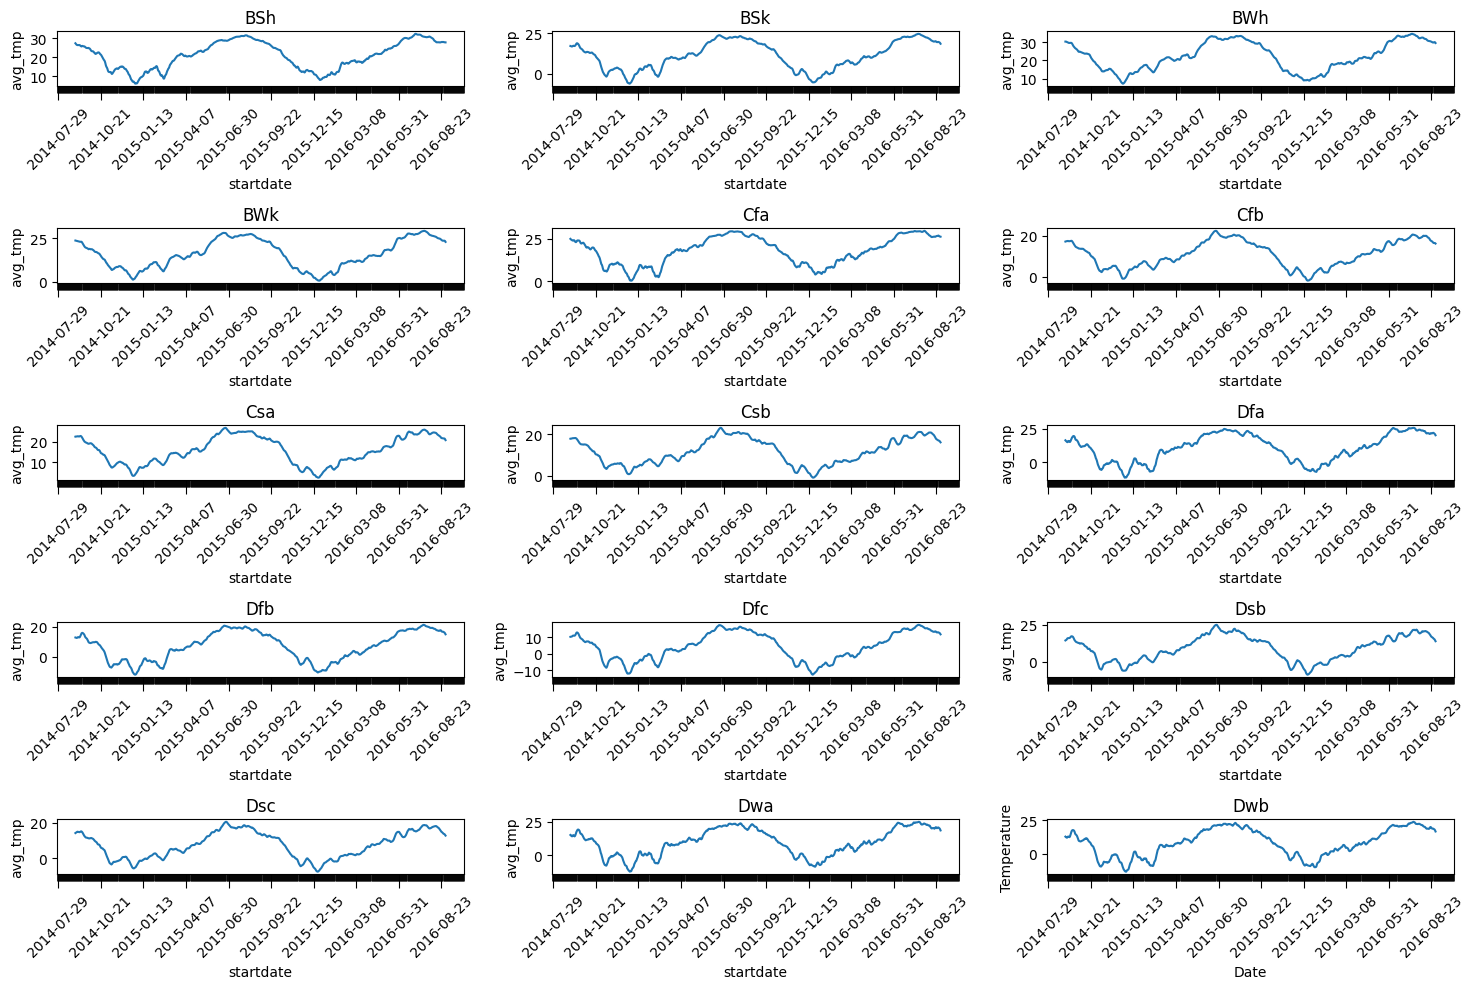

In [22]:
# prepare the figure
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))

# set the regions
regions = avg_tmp_df['region'].unique()

# iterate through the regions
for i, region in enumerate(regions):
    ax = axs[i//3, i%3]
    data = avg_tmp_df[avg_tmp_df['region'] == region]
    sns.lineplot(ax = ax, x='startdate', y='avg_tmp', data=data)
    ax.set_title(region)
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1, interval = 12))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)
    ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))
    ax.tick_params(axis = 'x', which = 'major', length = 10)
    ax.tick_params(axis = 'x', which = 'minor', length = 5)
    plt.xlabel('Date')
    plt.ylabel('Temperature')

# adjust the layout
fig.tight_layout()

# display the plot
plt.show()

### Variation of temperature by region

When we calculate the mean and standard deviation for each region and startdate, and then sort the result by descending std, we can see that the temperatures can differ quite significantly between locations. The count shows us how many locations there are for a specific region.

In [23]:
agg_temp = train_df.groupby(['region', 'startdate'])['target_tmp']\
                .agg(Mean='mean', Std='std', Count='count')\
                .sort_values('Std', ascending = False).reset_index()

agg_temp.head(10)

,region,startdate,Mean,Std,Count
0,Csa,2014-11-08,8.570182,7.635407,13
1,Csa,2014-11-09,8.289784,7.538632,13
2,Csa,2014-11-10,7.875758,7.518483,13
3,Csa,2014-11-07,8.987362,7.510783,13
4,Dfb,2015-02-06,-3.435579,7.497692,72
5,Dfb,2015-02-01,-3.593637,7.466386,72
6,Dfb,2015-02-09,-5.412851,7.428983,72
7,Dfb,2015-02-02,-3.111648,7.409277,72
8,Dfb,2015-02-05,-3.327157,7.386860,72
9,Dfb,2015-02-08,-4.411949,7.367470,72


When we check the temperature difference for a specific date, we can see that some regions have a large spread of the date, and others a very small one. What this tells us is that we cannot rely too much on the region alone for our predictions, but should use location.

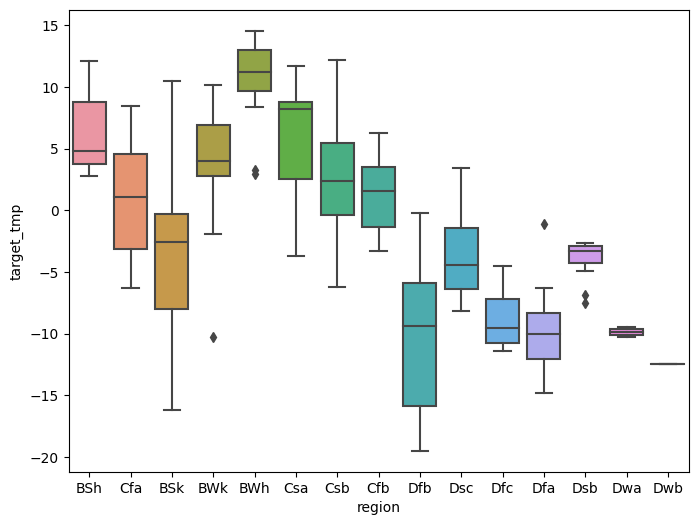

In [24]:
# for the 01/01/2015, how much did temperature differ per region?

specific_date_df = train_df[train_df['startdate'] == '2015-01-01']

fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x="region", y="target_tmp", data=specific_date_df, ax=ax)
plt.show()

### Performance of forecasting models

In [25]:
# subset df to only contain nmme columns, startdate, lon_lat and target for visualisation
df_filtered = train_df.filter(regex='^nmme-tmp|^nmme0-tmp|^nmme0mean|^target|^startdate|^lon_lat')
df_filtered.head()

,startdate,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,...,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,nmme0mean,lon_lat
0,2014-09-01,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65,0.83333333333333_0.0
1,2014-09-02,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65,0.83333333333333_0.0
2,2014-09-03,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65,0.83333333333333_0.0
3,2014-09-04,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65,0.83333333333333_0.0
4,2014-09-05,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65,0.83333333333333_0.0


In [26]:
# choose a smaller date range and a specific location

one_year_one_location_df = df_filtered[(df_filtered['startdate']< '2015-08-31') & (df_filtered['lon_lat']== '0.83333333333333_0.0')]
del one_year_one_location_df['lon_lat']
one_year_one_location_df.head()


,startdate,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,...,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,nmme0mean
0,2014-09-01,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65
1,2014-09-02,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65
2,2014-09-03,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65
3,2014-09-04,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65
4,2014-09-05,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,30.65


We can see that all forecasting models have get the overall trend correctly, but are quire far off in certain months, especially January and March. Some forecasting models only forecast the average of a month.

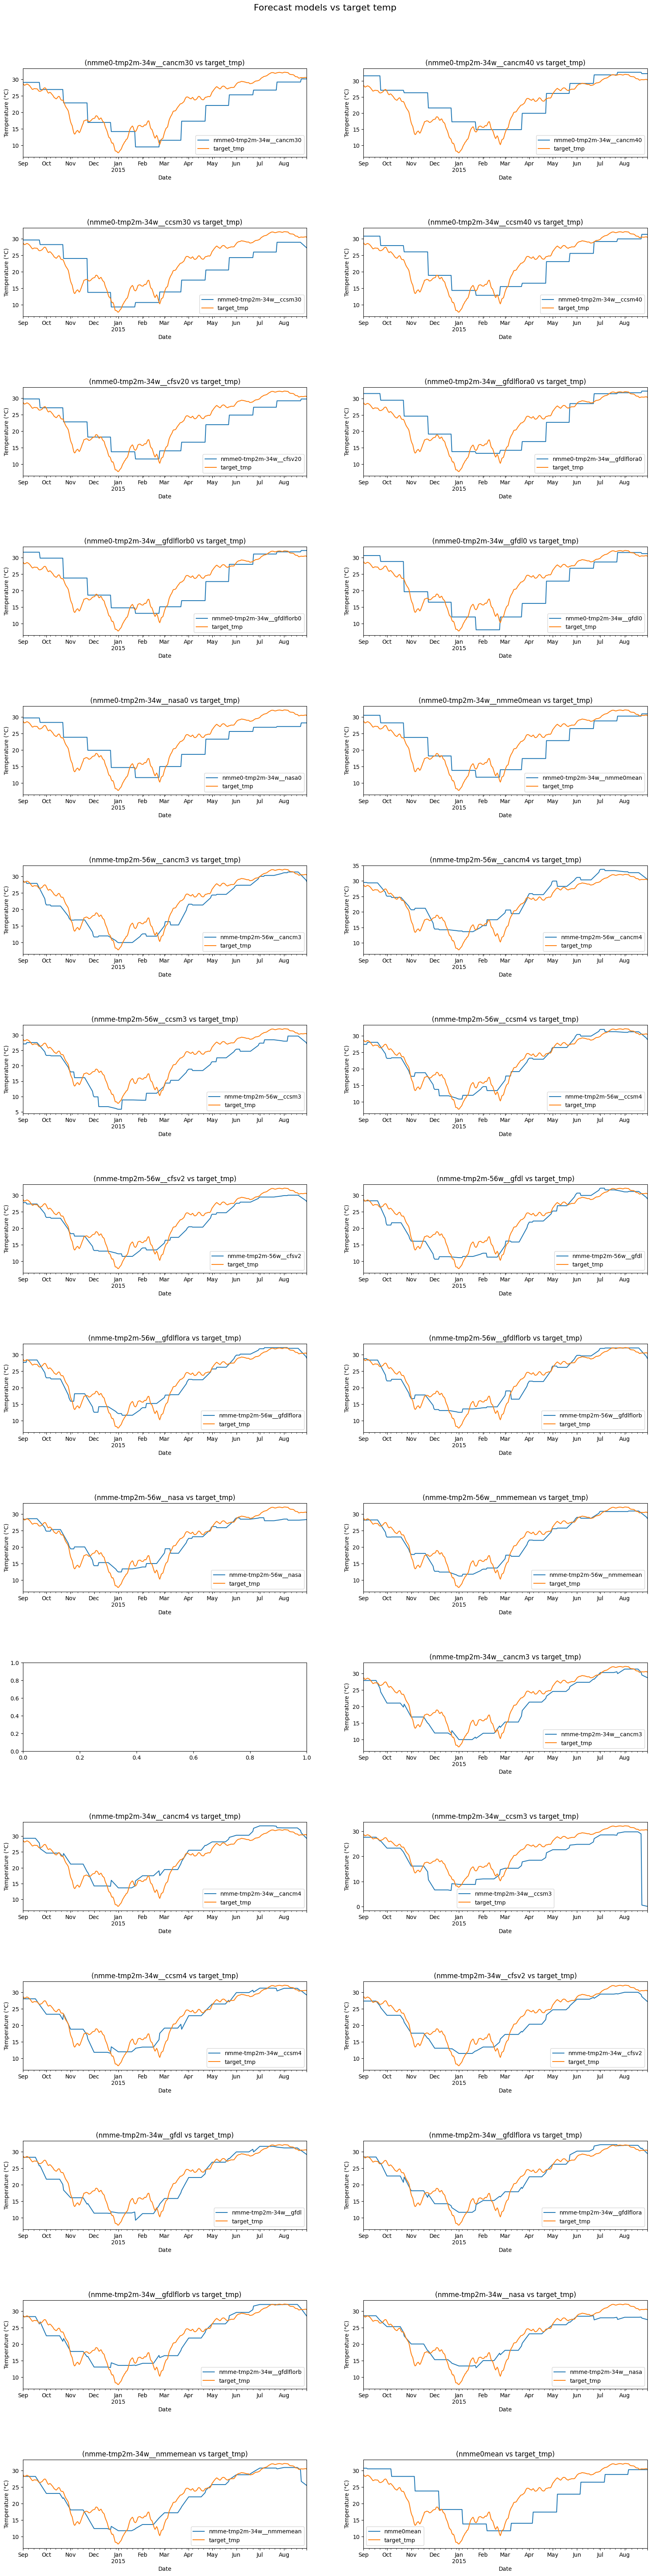

In [27]:
# plot the forecasts vs target_tmp

one_year_one_location_df.set_index('startdate', inplace=True)

# define subplot grid
fig, axs = plt.subplots(nrows=16, ncols=2, figsize=(20, 80))
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Forecast models vs target temp", fontsize=16, y=0.9)

# Loop through the temperature forecasting columns
for i, column in enumerate(one_year_one_location_df.columns):
    if column != 'target_tmp':
        # Access the current axis within the subplots grid
        ax = axs[i // 2, i % 2]

        # Create a line plot of the current temperature column and target_tmp
        one_year_one_location_df[[column, 'target_tmp']].plot(kind='line', ax=ax)

        # Add a title and labels for the x and y axis
        ax.set_title(f'({column} vs target_tmp)')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')

plt.show()

### Calculate RMSE of forcasts

Out of curiosity, let's check how well the various forecast models do by calculating their RMSE. We can then later see whether our model performs better.

We can see that the RMSE of the different models is between 3.25 and 7.83. Our final model does significantly better than that.

In [28]:
# get all the columns which contain forecasts
forecasts_df = train_df.filter(regex='^nmme-tmp|^nmme0-tmp|nmme0$|^target|^cancm30|^cancm40|^ccsm30|^ccsm40|^cfsv20')

actual = forecasts_df['target_tmp']

model_rmse = []

for column in forecasts_df.columns:
    if column != 'target_tmp':
        predicted = forecasts_df[column]
        mse = sklearn.metrics.mean_squared_error(actual, predicted)
        rmse = math.sqrt(mse)
        model_rmse.append((column,rmse))

# Sort the list based on the rmse
sorted_rmse = sorted(model_rmse, key=lambda x: x[1])

# Print the sorted rmse
for key, value in sorted_rmse:
    print(key, value)

nmme-tmp2m-34w__cfsv2 3.2484589237476587
nmme-tmp2m-56w__cfsv2 3.271164184864818
nmme-tmp2m-34w__nmmemean 3.418967380969409
nmme-tmp2m-34w__gfdlflorb 3.439617273494169
nmme-tmp2m-56w__nmmemean 3.446414655790314
nmme-tmp2m-56w__gfdlflorb 3.4804188267516625
nmme-tmp2m-56w__gfdlflora 3.4935069363826656
nmme-tmp2m-34w__gfdlflora 3.5185768490006555
nmme-tmp2m-56w__ccsm4 3.605571790391836
nmme-tmp2m-34w__ccsm4 3.6083415974745217
nmme-tmp2m-34w__gfdl 3.865411727530525
nmme-tmp2m-56w__gfdl 3.894275294913568
nmme-tmp2m-34w__cancm3 4.3496582374476676
nmme-tmp2m-34w__cancm4 4.400928235523994
nmme-tmp2m-56w__cancm4 4.4287741550038495
nmme-tmp2m-56w__cancm3 4.449405977690274
nmme-tmp2m-34w__nasa 4.5125498364678505
nmme-tmp2m-56w__nasa 4.5890912230563865
nmme-tmp2m-56w__ccsm3 4.685923776369252
nmme-tmp2m-34w__ccsm3 4.934481984322544
nmme0-tmp2m-34w__cfsv20 5.200209294360366
nmme0-tmp2m-34w__nmme0mean 5.633671046326305
nmme0-tmp2m-34w__gfdlflora0 5.7060386485106775
nmme0-tmp2m-34w__gfdlflorb0 5.70936

### Data Drift

Our data contains a large amount of data drift, which happens when the distribution of the data changes over time. Since there is a gap of 6 years between our train and our test data, this is not surprising. One way to handle data drift is to take out the features which have a large amount of drift. This has been done further below, as it improved the performance of the model.

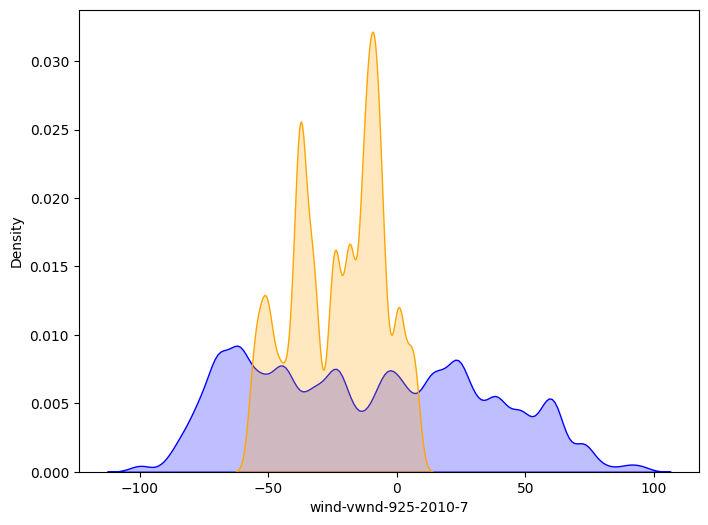

In [29]:
# example of column with a lot of data drift (not all columns are displayed here, since there is a large amount)
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()
sns.kdeplot(data=train_df['wind-vwnd-925-2010-7'],  color='blue', fill=True, ax=ax)
sns.kdeplot(data=test_df['wind-vwnd-925-2010-7'], color='orange', fill=True, ax=ax)
plt.show()

### Correlation matrices

Let's check for correlation between similar types of columns

In [30]:
def filter_df(df, string):
    filtered_df = df.filter(regex=f'^{string}|^target_tmp')
    return filtered_df


In [31]:
icec_df = filter_df(train_df, "icec")
icec_df.head()

,target_tmp,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10
0,28.744480,-4.33,0.97,0.15,-0.16,-0.08,0.15,-0.06,0.03,0.03,0.13
1,28.370585,-4.33,0.97,0.15,-0.16,-0.08,0.15,-0.06,0.03,0.03,0.13
2,28.133059,-4.33,0.97,0.15,-0.16,-0.08,0.15,-0.06,0.03,0.03,0.13
3,28.256798,-4.33,0.97,0.15,-0.16,-0.08,0.15,-0.06,0.03,0.03,0.13
4,28.372353,-4.33,0.97,0.15,-0.16,-0.08,0.15,-0.06,0.03,0.03,0.13


In [32]:
# nmme_prate_df = filter_df(train_df, "nmme-prate")
# nmme0_prate_df = filter_df(train_df, "nmme0-prate")
prate_df = filter_df(train_df, "nmme0-prate|nmme-prate")
# nmme_tmp_df = filter_df(train_df, "nmme-tmp")
# nmme0_tmp_df = filter_df(train_df, "nmme0-tmp")
# sst_df = filter_df(train_df, "sst")
# wind_hgt_10_df = filter_df(train_df, "wind-hgt-10-")
# wind_hgt_850_df = filter_df(train_df, "wind-hgt-850-")
# wind_uwnd_250_df = filter_df(train_df, "wind-uwnd-250")
# wind_vwnd_250_df = filter_df(train_df, "wind-vwnd-250")
contest_wind_df = filter_df(train_df, "contest-wind")

In [33]:
def create_corr_matrix(df): 

    # Compute the correlation matrix
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 210, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr,cmap=cmap, annot=True, vmin=-1, vmax=1, center=0)

    plt.show()

Only two examples of the correlation matrix is shown here. Removing columns which had a high correlation did not lead to prediction improvements  in our model

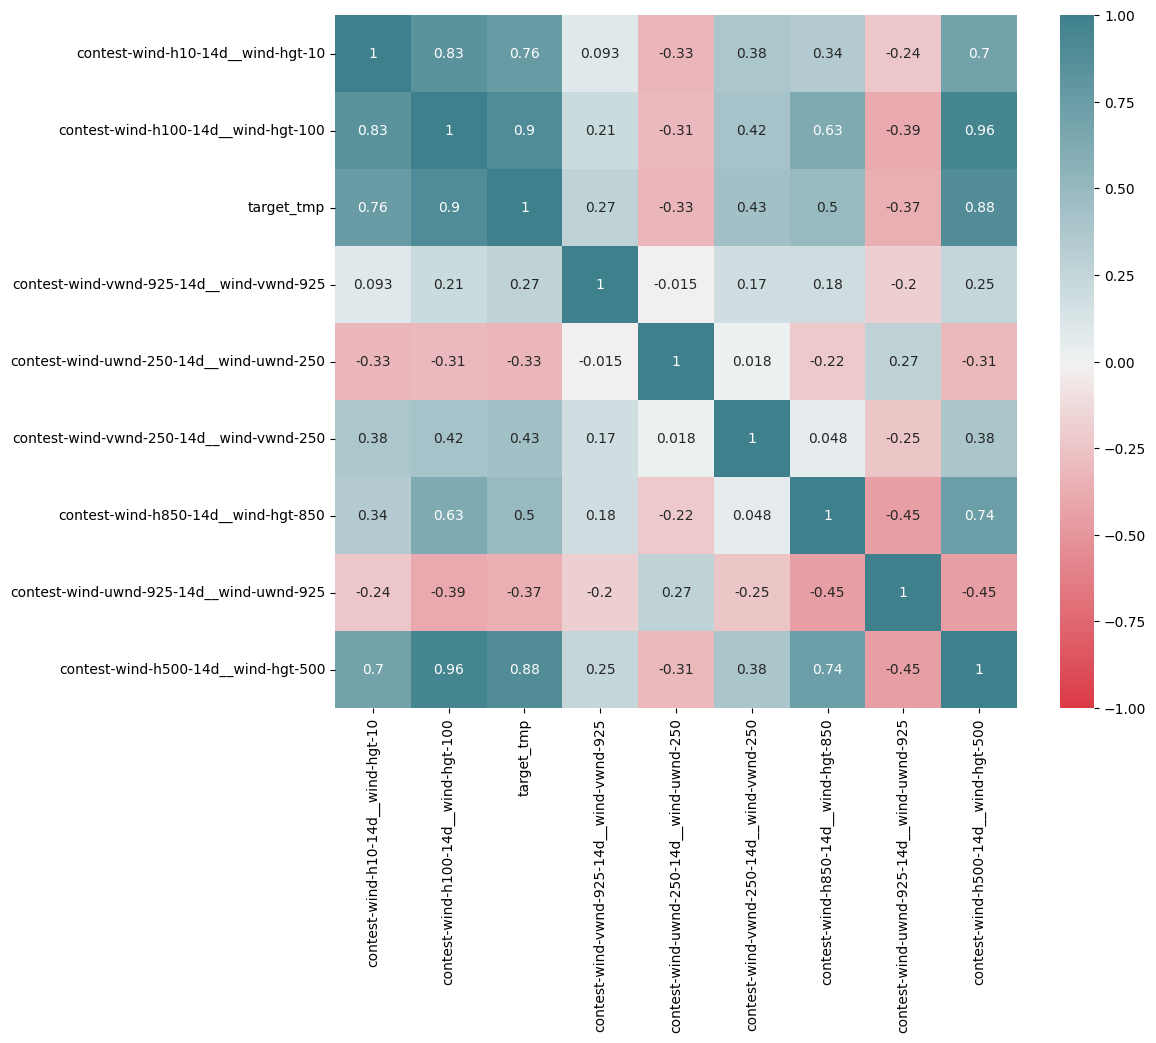

In [34]:
create_corr_matrix(contest_wind_df)

In [35]:
# create_corr_matrix(most_important_features_df)

In [36]:
# create_corr_matrix(icec_df)

In [37]:
# create_corr_matrix(nmme_prate_df)

In [38]:
# create_corr_matrix(nmme0_prate_df)

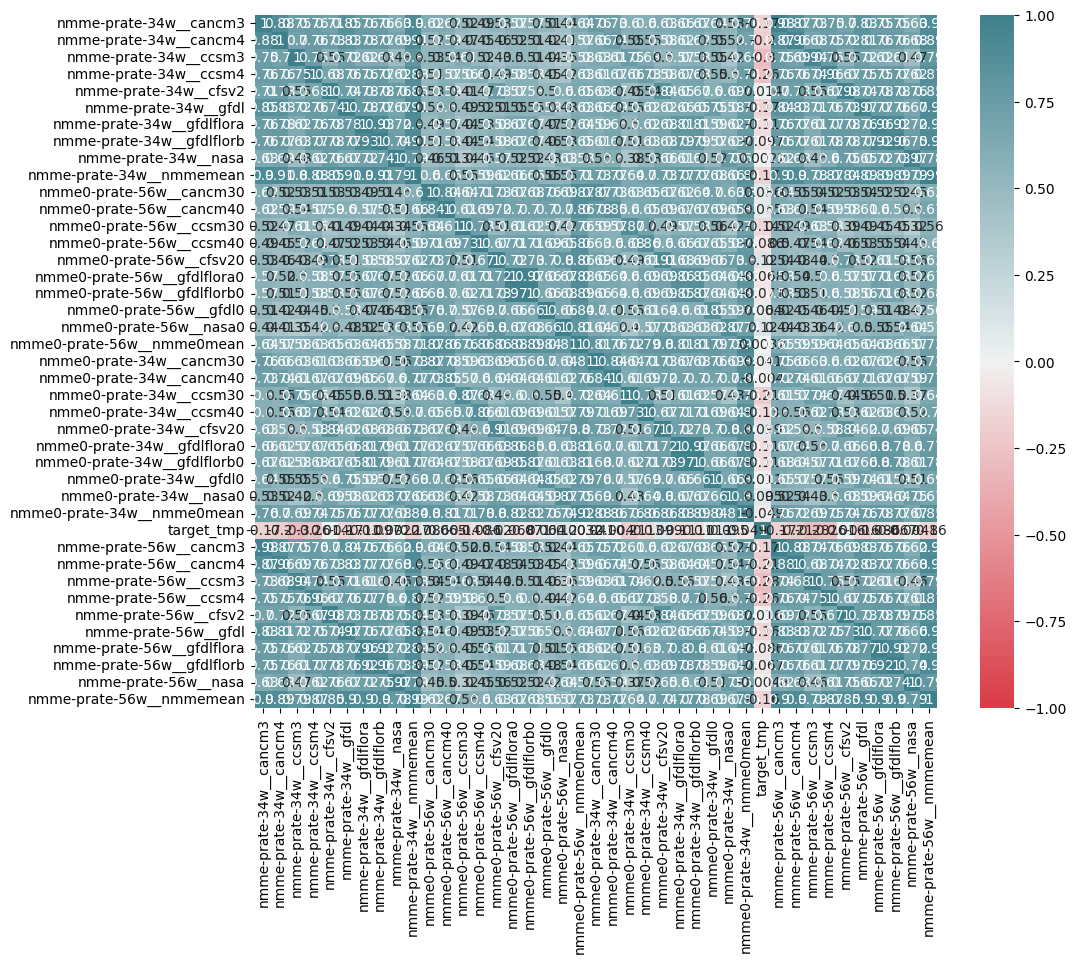

In [39]:
create_corr_matrix(prate_df)

In [40]:
# create_corr_matrix(nmme_tmp_df)

In [41]:
# create_corr_matrix(nmme0_tmp_df)

In [42]:
# create_corr_matrix(sst_df)

In [43]:
# create_corr_matrix(wind_hgt_850_df)

In [44]:
# create_corr_matrix(wind_uwnd_250_df)

In [45]:
# create_corr_matrix(wind_vwnd_250_df)

## Feature engineering


* Take average of prate columns
* Remove most temperature forecasting models
* Create time features based on date
* Make time features cyclical where necesarry (e.g. day, week, month)
* Encode categorical variables

### Average of prate columns

The prate features are the forecasting models' prediction for precipitation. Since they are highly correlated as seen above we take their average and drop the rest.

In [46]:
prate_cols = train_df.filter(regex='^nmme0-prate').columns
train_df['prate_avg'] = train_df[prate_cols].mean(axis=1)
test_df['prate_avg'] = test_df[prate_cols].mean(axis=1)

train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,lon_lat,prate_avg
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0.83333333333333_0.0,11.867
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0.83333333333333_0.0,11.867
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0.83333333333333_0.0,11.867
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0.83333333333333_0.0,11.867
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0.83333333333333_0.0,11.867


### Remove most  forecasting models

After training the model it became apparent that it is not useful to have all the different forecast models in the training data. So we only leave the average of the models, namely 'nmme0mean'. Some of the columns with strong data drift will be removed too.

In [47]:
# create a df which does not contain the forecasts and certain columns with a lot of data drift

forecast_models_col_list = train_df.filter(regex='^nmme|^cancm|^ccsm|cfsv20|nasa0|gfdlflora0|gfdlflorb0|gfdl0|^icec')\
                         .columns.tolist()

#leave only the nmme0mean model, the average of several of the forecasting models
forecast_models_col_list.remove('nmme0mean')
forecast_models_col_list

train_df = train_df.drop(forecast_models_col_list, axis=1)
test_df = test_df.drop(forecast_models_col_list, axis=1)

### Create time based features

In [48]:
# Resource: https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=p8piDWNxFq0H

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    
    # encode the day with a period of 365
    df['day_sin'] = sin_transformer(365).fit_transform(df['startdate'].dt.day)
    df['day_cos'] = cos_transformer(365).fit_transform(df['startdate'].dt.day)

    # encode the week with a period of 52
    df['week_sin'] = sin_transformer(52).fit_transform(df['startdate'].dt.isocalendar().week)
    df['week_cos'] = cos_transformer(52).fit_transform(df['startdate'].dt.isocalendar().week)

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['startdate'].dt.month)
    df['month_cos'] = cos_transformer(12).fit_transform(df['startdate'].dt.month)
    
    # year does not need encoding
    df['year'] = df['startdate'].dt.year 

In [49]:
encode_cyclical(train_df)
encode_cyclical(test_df)
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,target_tmp,contest-slp-14d__slp,...,wind-vwnd-925-2010-20,lon_lat,prate_avg,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,year
0,0,0.0,0.833333,2014-09-01,237.00,31246.63,81.72,16666.81,28.744480,101352.08,...,4.58,0.83333333333333_0.0,11.867,0.017213,0.999852,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
1,1,0.0,0.833333,2014-09-02,228.90,31244.78,82.56,16667.31,28.370585,101396.02,...,3.42,0.83333333333333_0.0,11.867,0.034422,0.999407,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
2,2,0.0,0.833333,2014-09-03,220.69,31239.27,83.29,16668.39,28.133059,101429.25,...,4.82,0.83333333333333_0.0,11.867,0.051620,0.998667,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
3,3,0.0,0.833333,2014-09-04,225.28,31232.86,83.26,16667.39,28.256798,101440.85,...,9.74,0.83333333333333_0.0,11.867,0.068802,0.997630,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
4,4,0.0,0.833333,2014-09-05,237.24,31226.16,82.50,16665.65,28.372353,101419.53,...,10.95,0.83333333333333_0.0,11.867,0.085965,0.996298,-0.935016,-0.354605,-1.0,-1.836970e-16,2014


### Encode categorical variables

One-hot-encoding has been used first, but Target encoding has lead to better results in this case

#### One-hot-encoding

In [50]:
# # encode categorical variables so that they can be used by the model

# train_df_onehot = no_fc_df.copy()
# train_df_onehot = pd.get_dummies(train_df_onehot, columns=['year', 'month', 'week','day', 'region', 'lon_lat'])

# #drop columns we don't need anymore
# train_df_onehot = train_df_onehot.drop(['lon', 'lat'], axis=1)

# train_df_onehot.head()

#### Target encoding

In [51]:
# set up the encoder
encoder = TargetEncoder(cols=['region', 'lon_lat'], smoothing = 10)

# fit the encoder - finds the mean target value per category
train_df_no_target = train_df.drop(['target_tmp'], axis=1)
encoder.fit(train_df_no_target, train_df['target_tmp'])

# transform data
encoded_df_train = encoder.transform(train_df_no_target)
encoded_df_test = encoder.transform(test_df)

# getting error saying this is not float, so converting it here
encoded_df_train['week_cos'] = encoded_df_train['week_cos'].astype(float)
encoded_df_train['week_sin'] = encoded_df_train['week_sin'].astype(float)
encoded_df_test['week_cos'] = encoded_df_test['week_cos'].astype(float)
encoded_df_test['week_sin'] = encoded_df_test['week_sin'].astype(float)

encoded_df_train.drop(['index', 'lat', 'lon'], axis=1, inplace=True)
encoded_df_test.drop(['index','lat', 'lon'], axis=1, inplace=True)

encoded_df_train_no_target = encoded_df_train
encoded_df_train = pd.concat([encoded_df_train,train_df['target_tmp']], axis=1)
encoded_df_train.head()
# encoded_df_test.head()

,startdate,contest-pevpr-sfc-gauss-14d__pevpr,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-prwtr-eatm-14d__prwtr,...,lon_lat,prate_avg,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,year,target_tmp
0,2014-09-01,237.00,31246.63,81.72,16666.81,101352.08,4.41,98644.97,-2.56,42.45,...,23.474873,11.867,0.017213,0.999852,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.744480
1,2014-09-02,228.90,31244.78,82.56,16667.31,101396.02,3.74,98686.80,-2.39,42.66,...,23.474873,11.867,0.034422,0.999407,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.370585
2,2014-09-03,220.69,31239.27,83.29,16668.39,101429.25,3.40,98712.85,-2.76,43.23,...,23.474873,11.867,0.051620,0.998667,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.133059
3,2014-09-04,225.28,31232.86,83.26,16667.39,101440.85,3.29,98711.70,-3.00,43.11,...,23.474873,11.867,0.068802,0.997630,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.256798
4,2014-09-05,237.24,31226.16,82.50,16665.65,101419.53,3.27,98686.46,-3.40,42.98,...,23.474873,11.867,0.085965,0.996298,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.372353


## The LGB model

### Spliting the training data

NOTE: It is not advisable to use cross validation in this case, since the model's performance will be overly optimistic. This is due to the time component of the data: If we use CV, then we will have the same date for the training and hold out data set and the model can learn from similar locations for the same day. To avoid this, we simply leave the last 2 months as a hold out set, and use the rest to train the model.

In [52]:
train = encoded_df_train.loc[encoded_df_train['startdate'] < '2016-07-01' ]
validation = encoded_df_train.loc[encoded_df_train['startdate'] >= '2016-07-01' ]

In [53]:
train = train.drop(['startdate'], axis=1)
len(train)

343866

In [54]:
validation = validation.drop(['startdate'], axis=1)
len(validation)

31868

In [55]:
no_target = train.drop(['target_tmp'], axis=1)
no_target.head()

,contest-pevpr-sfc-gauss-14d__pevpr,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,...,wind-vwnd-925-2010-20,lon_lat,prate_avg,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,year
0,237.00,31246.63,81.72,16666.81,101352.08,4.41,98644.97,-2.56,42.45,-3.52,...,4.58,23.474873,11.867,0.017213,0.999852,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
1,228.90,31244.78,82.56,16667.31,101396.02,3.74,98686.80,-2.39,42.66,-4.49,...,3.42,23.474873,11.867,0.034422,0.999407,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
2,220.69,31239.27,83.29,16668.39,101429.25,3.40,98712.85,-2.76,43.23,-5.44,...,4.82,23.474873,11.867,0.051620,0.998667,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
3,225.28,31232.86,83.26,16667.39,101440.85,3.29,98711.70,-3.00,43.11,-5.76,...,9.74,23.474873,11.867,0.068802,0.997630,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
4,237.24,31226.16,82.50,16665.65,101419.53,3.27,98686.46,-3.40,42.98,-6.09,...,10.95,23.474873,11.867,0.085965,0.996298,-0.935016,-0.354605,-1.0,-1.836970e-16,2014


In [56]:
#Get the list of all column names from headers
features = list(no_target.columns.values)
target = 'target_tmp'


In [57]:
X_train = train[features]
y_train = train[target]

X_val = validation[features]
y_val = validation[target]

### Training the model

In [58]:
lgbm = LGBMRegressor(n_estimators=5000, learning_rate = 0.05, max_depth = 6, seed=30, early_stopping_rounds = 100, loss_function='RMSE', reg_lambda=2)
lgbm.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = 100)


[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.2819	valid_1's l2: 2.17414
[200]	training's l2: 0.821957	valid_1's l2: 1.60713
[300]	training's l2: 0.643399	valid_1's l2: 1.42166
[400]	training's l2: 0.538471	valid_1's l2: 1.35658
[500]	training's l2: 0.473537	valid_1's l2: 1.2738
[600]	training's l2: 0.421696	valid_1's l2: 1.18696
[700]	training's l2: 0.382274	valid_1's l2: 1.14946
[800]	training's l2: 0.350482	valid_1's l2: 1.10895
[900]	training's l2: 0.325699	valid_1's l2: 1.07591
[1000]	training's l2: 0.303938	valid_1's l2: 1.0587
[1100]	training's l2: 0.285754	valid_1's l2: 1.04298
[1200]	training's l2: 0.268634	valid_1's l2: 1.02704
[1300]	training's l2: 0.254536	valid_1's l2: 1.02065
[1400]	training's l2: 0.24157	valid_1's l2: 1.01625
[1500]	training's l

LGBMRegressor(early_stopping_rounds=100, learning_rate=0.05,
              loss_function='RMSE', max_depth=6, n_estimators=5000,
              reg_lambda=2, seed=30)

### Feature Importance

Oftentimes a model performs better if we use the most relevant features only. Below we can see a plot of the feature importance scores for each feature in descending order. We cann see that there is a large gap from 286 to 847 and we will use a score of 300 as a cut-off point.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

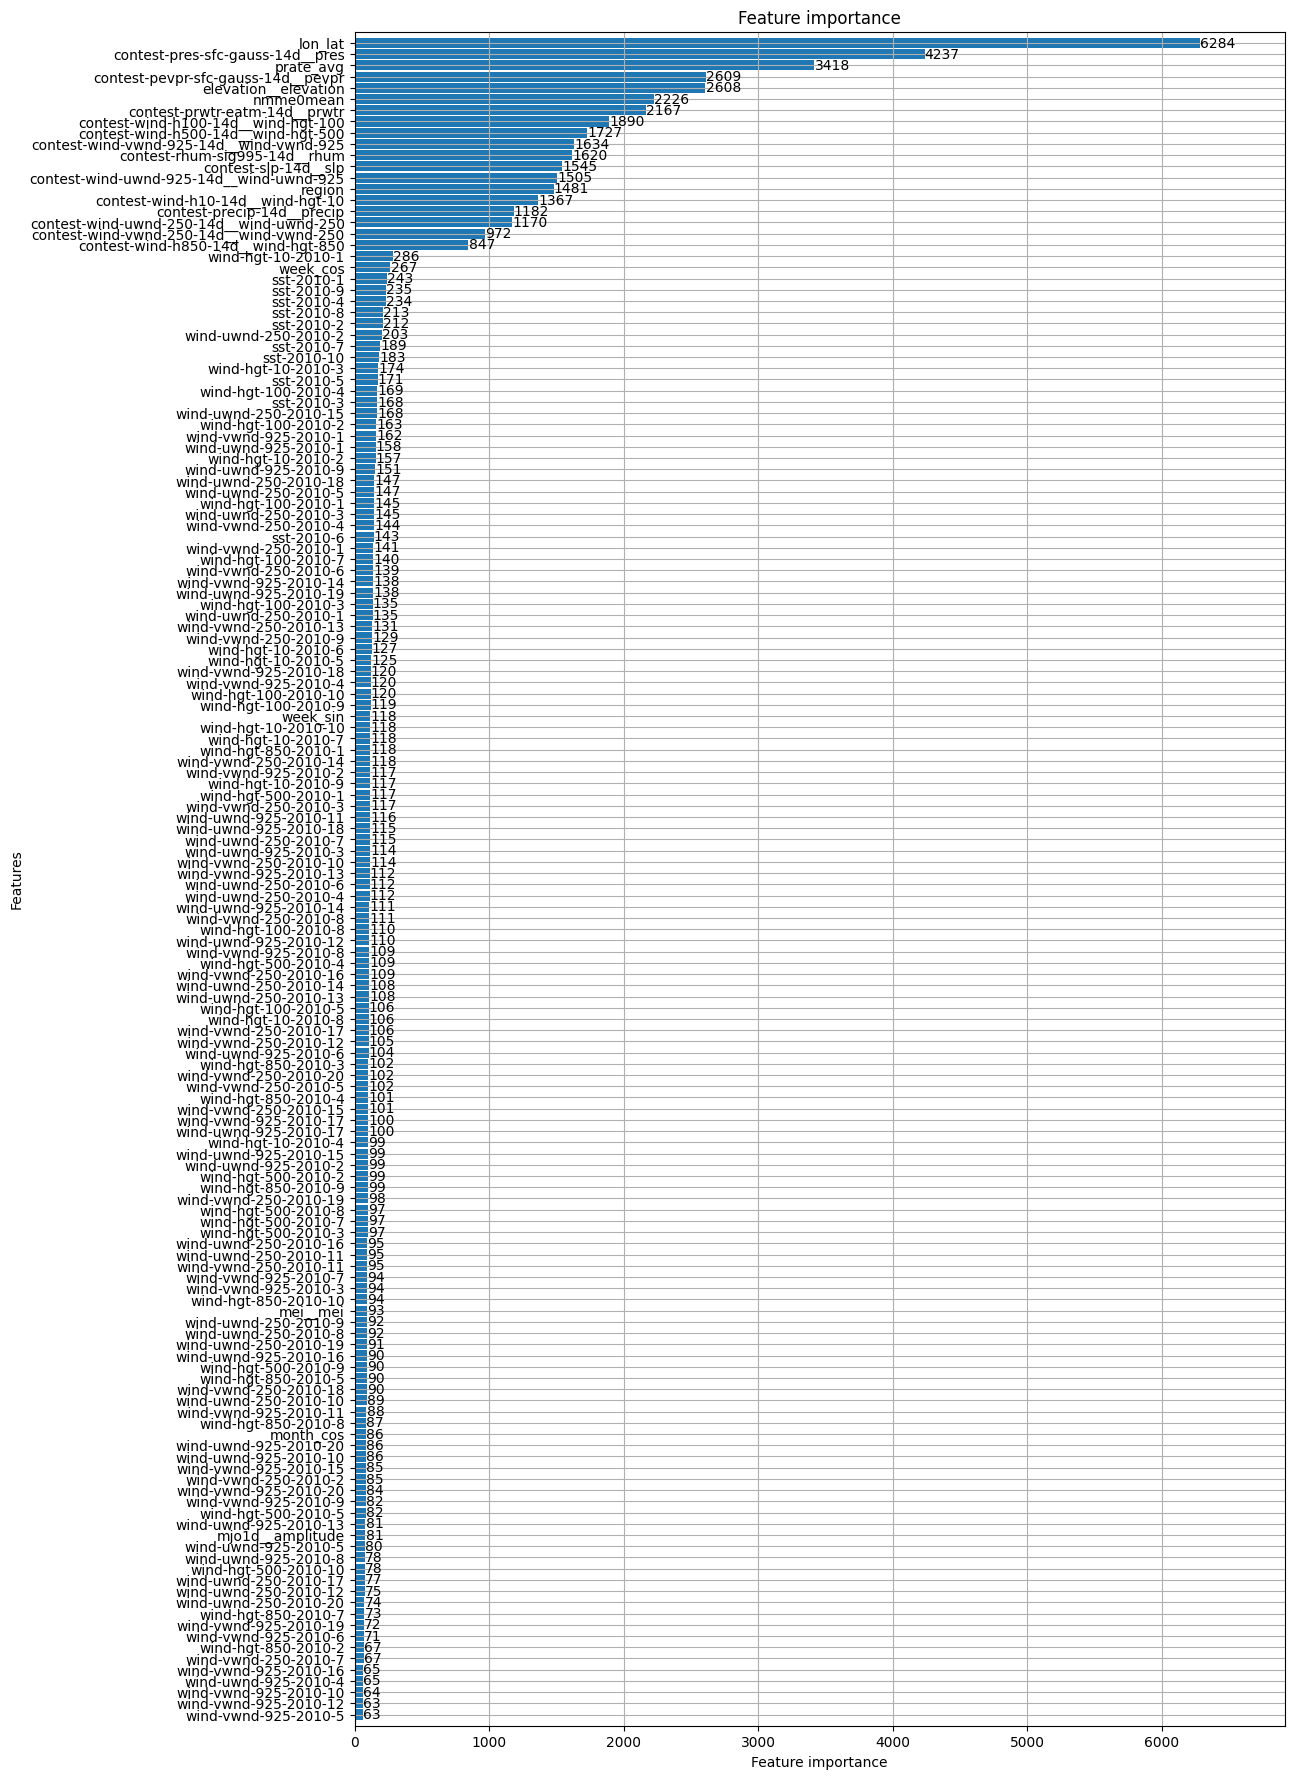

In [59]:
plt.rcParams["figure.figsize"] = (12, 22)

lightgbm.plot_importance(lgbm, max_num_features = 150, height=.9)

In [60]:
# Get feature importances
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_})
feature_importances.sort_values('importance', ascending = False, inplace = True)
feature_importances.head(20)

,feature,importance
152,lon_lat,6284
6,contest-pres-sfc-gauss-14d__pres,4237
153,prate_avg,3418
0,contest-pevpr-sfc-gauss-14d__pevpr,2609
16,elevation__elevation,2608
14,nmme0mean,2226
8,contest-prwtr-eatm-14d__prwtr,2167
3,contest-wind-h100-14d__wind-hgt-100,1890
13,contest-wind-h500-14d__wind-hgt-500,1727
5,contest-wind-vwnd-925-14d__wind-vwnd-925,1634


**With feature engineering and feature selection, we have reduced the amount of features from almost 250 to only 19.**

In [61]:
most_important_features = feature_importances[feature_importances['importance'] >= 300]['feature'].tolist()
len(most_important_features)

19

### Retraining the model with the most important features

We can see that the model improves when we select only the most important features (RMSE of 0.73 compared to 0.97 with all features). Of course it is more time efficient too.

In [62]:
X_train = train[most_important_features]
X_val = validation[most_important_features]

# training the model
lgbm = LGBMRegressor(n_estimators=5000, learning_rate = 0.05, max_depth = 6, seed=30, early_stopping_rounds = 100, loss_function='RMSE', reg_lambda=2)
lgbm.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = 100)



Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.68015	valid_1's l2: 1.91005
[200]	training's l2: 1.12165	valid_1's l2: 1.33241
[300]	training's l2: 0.889957	valid_1's l2: 1.15144
[400]	training's l2: 0.760652	valid_1's l2: 1.06417
[500]	training's l2: 0.673869	valid_1's l2: 1.01321
[600]	training's l2: 0.609936	valid_1's l2: 0.971639
[700]	training's l2: 0.557886	valid_1's l2: 0.935218
[800]	training's l2: 0.515928	valid_1's l2: 0.917422
[900]	training's l2: 0.48138	valid_1's l2: 0.893111
[1000]	training's l2: 0.452519	valid_1's l2: 0.877499
[1100]	training's l2: 0.427143	valid_1's l2: 0.859897
[1200]	training's l2: 0.406241	valid_1's l2: 0.845917
[1300]	training's l2: 0.385298	valid_1's l2: 0.834963
[1400]	training's l2: 0.367263	valid_1's l2: 0.829927
[1500]	training's l2: 0.350632	valid_1's l2: 0.820789
[1600]	training's l2: 0.336449	valid_1's l2: 0.810724
[1700]	training's l2: 0.322654	valid_1's l2: 0.801723
[1800]	training's l2: 0.309874	valid_

LGBMRegressor(early_stopping_rounds=100, learning_rate=0.05,
              loss_function='RMSE', max_depth=6, n_estimators=5000,
              reg_lambda=2, seed=30)

### Training the final model

In [63]:
# concatinating our training data with the hold out set, so that we have the complete data to train our model on

X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val] , axis=0)

In [64]:
lgbm = LGBMRegressor(n_estimators=5000, learning_rate = 0.05, max_depth = 6, seed=30, loss_function='RMSE', reg_lambda=2)
lgbm.fit(X_train_final, y_train_final, verbose = False)

LGBMRegressor(learning_rate=0.05, loss_function='RMSE', max_depth=6,
              n_estimators=5000, reg_lambda=2, seed=30)

In [65]:
# loading the sample submission file
submission = pd.read_csv('sample_solution.csv')
submission.head()

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738


### Making predictions

In [66]:
# making predictions and replacing the values of the sample file
target_variable = 'contest-tmp2m-14d__tmp2m'
submission[target_variable] = lgbm.predict(encoded_df_test[most_important_features])

In [67]:
submission.head(5)

,contest-tmp2m-14d__tmp2m,index
0,29.067098,375734
1,28.835341,375735
2,28.800282,375736
3,29.065366,375737
4,29.167373,375738


In [68]:
#save the submission file
submission.to_csv('submission.csv', index = False)

## Other approches

Several other approaches have been used in order to improve the model, however, the solution above gave the best results. Some of the other approaches included:

* **Removing highly correlated variables**: 
The correlation between all columns was checked and columns were removed based on a threshold of 0.9. Hoever, this did not improve the model's performance, perhaps because LGB is good in dealing with correlated variables and some of the correlation has already been removed by taking the averages of the forecasting models for temperature and precipitation. 


* **Adversial validation:** 
Adversial validation has been used to figure out which columns have the greatest data drift and to remove them. This works by merging the training and testing data, but distinguishing them with a 0 or 1 respectively, and then training a model to predict whether data comes either from the train dataset or from the test dataset. The idea behind this is that the most important features of this model will be the ones with the largest data drift. However, choosing the columns to remove by looking at the visualisation lead to better results, thus this method was not used in the final solution.


* **PCA for dimensionality reduction:**
Pricipal component analysis (PCA) is a useful tool for dimensionality reduction (when we have a large amount of features relative to observations) and to do exploratory data analysis of high dimensional data. PCA reduces the amount of features by creating a smaller number of representitive variables which explain most of the variability in the data. The first principal component contains the most information of the data, and the last principal component the least. A scree plot has been used to identidy how many components to use. 20 principal components explained around 80% of the variability of the data and 50 principal components explained almost 100% of the variability. However, PCA did not lead to any improvements of the model. 


* **Hyperparameter tuning:**
Has been performed with different approaches such as Optuna, and the best parameters have been chosen in the solution above.

## Conclusion

This notebook shows the usefulness of machine learning for weather prediction, as the model outperforms the traditional forecasting models (by making use of them together with location, time and weather data). It also shows the importance of feature engineering and feature selection. We started with almost 250 features but our final model uses less than 20.